In [0]:
!cat /proc/cpuinfo
!nvidia-smi

Importing modules needed to run program

In [1]:
!pip install --user tensorflow==2.0.0-alpha

     |████████████████████████████████| 79.9MB 1.2MB/s 
     |████████████████████████████████| 3.0MB 44.7MB/s 
     |████████████████████████████████| 419kB 51.5MB/s 
     |████████████████████████████████| 61kB 9.9MB/s 
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [3]:

import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import pandas as pd
import scipy.misc
from scipy.stats import itemfreq
from statsmodels.tools import categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions, ResNet50
import os
from os import listdir, getcwd
from os.path import isfile, join, dirname, abspath
import pickle
import time
import math
from datetime import timedelta
from zipfile import ZipFile
from io import BytesIO
import PIL.Image
import matplotlib.pyplot as plt
from IPython.display import display
tf.__version__

'1.13.1'

Check out hardware stats

Linking Google Drive with Collab

In [4]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

     |████████████████████████████████| 993kB 3.5MB/s 


Downloading labels.csv, train.zip, and test.zip.

In [0]:
link = 'https://drive.google.com/open?id=1lhUvUznD_r1dTGv7wZI_RNH18HOyd8yv'
fluff, id = link.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('labels.csv') 

link = 'https://drive.google.com/open?id=1poX95lT6DrIH3GnAshcmATD3cMfynfa5'
fluff, id = link.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('train.zip')

link = 'https://drive.google.com/open?id=1tqFoSKWqiqq_-LMeWqbvOcHJKzdty5X1'
fluff, id = link.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('test.zip') 


Declaring standard variables. We have to manually calculate the number of epochs so that we run roughly the number of iterations we did in the TensorFlow implementation.

The TensorFlow implementation runs for 3500 iterations with a batch size of 50 each time. The size of the test data is 645. 645 / 50 ≈ 13. So it takes 13 iterations to fully traverse the dataset. 3500 / 13 ≈ **270 epochs**.
 



In [0]:
img_size = 60
batch_size = 50
epochs = 270 # Check note above.

filter_size1 = 20 
num_filters1 = 32       

filter_size2 = 15        
num_filters2 = 64 

filter_size3 = 10
num_filters3 = 128

Nber_of_breeds = 8

Function needed for turning the training and test zip files into a pickle

In [0]:
def DataBase_creator(archivezip, nwidth, nheight, save_name):
    start_time = time.time()
    
    s = (len(archivezip.namelist()[:])-1, nwidth, nheight,3)
    allImage = np.zeros(s)

    for i in range(1,len(archivezip.namelist()[:])):
        filename = BytesIO(archivezip.read(archivezip.namelist()[i]))
        image = PIL.Image.open(filename) # open colour image
        image = image.resize((nwidth, nheight))
        image = np.array(image)
        image = np.clip(image/255.0, 0.0, 1.0)

        allImage[i-1]=image
    
    pickle.dump(allImage, open( save_name + '.p', "wb" ) )
    
    end_time = time.time()
    time_dif = end_time - start_time
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

Function for selecting N numbered dog breeds from dataset

In [0]:
def main_breeds(labels_raw, Nber_breeds , all_breeds='TRUE'):
    labels_freq_pd = itemfreq(labels_raw["breed"])
    labels_freq_pd = labels_freq_pd[labels_freq_pd[:, 1].argsort()[::-1]] #[::-1] ==> to sort in descending order
    
    if all_breeds == 'FALSE':
        main_labels = labels_freq_pd[:,0][0:Nber_breeds]
    else: 
        main_labels = labels_freq_pd[:,0][:]
        
    labels_raw_np = labels_raw["breed"].as_matrix() #transform in numpy
    labels_raw_np = labels_raw_np.reshape(labels_raw_np.shape[0],1)

    labels_filtered_index = np.where(labels_raw_np == main_labels)

    return labels_filtered_index

Unzipping the zipfile

In [11]:
archive_train = ZipFile("train.zip", 'r')
archive_test = ZipFile("test.zip", 'r')
archive_train.namelist()[0:5]
len(archive_train.namelist()[:])-1

10222

Creating the pickle files

In [12]:
DataBase_creator(archive_train, img_size, img_size , "train")
DataBase_creator(archive_test, img_size, img_size , "test")

Time usage: 0:00:44
Time usage: 0:00:42


Load the pickle files

In [13]:
train = pickle.load( open( "train.p", "rb" ) )
test = pickle.load(open( "test.p", "rb" ))
print(train.shape)
print(test.shape)

(10222, 60, 60, 3)
(10357, 60, 60, 3)


Label preparation

In [14]:
labels_raw = pd.read_csv('labels.csv')
labels_filtered_index = main_breeds(labels_raw = labels_raw, Nber_breeds = Nber_of_breeds, all_breeds='FALSE')
labels_filtered = labels_raw.iloc[labels_filtered_index[0],:]
train_filtered = train[labels_filtered_index[0],:,:,:]

print('- Number of images remaining after selecting the {0} main breeds : {1}'.format(Nber_of_breeds, labels_filtered_index[0].shape))
print('- The shape of train_filtered dataset is : {0}'.format(train_filtered.shape))
name_labels = labels_filtered.breed.unique() 
for i in range(Nber_of_breeds):
  print("Breed {0}: {1}".format(i, name_labels[i]))

labels = np.asarray(labels_filtered["breed"])    
labels = pd.Series(labels, dtype="category")
labels = labels.cat.codes



- Number of images remaining after selecting the 8 main breeds : (922,)
- The shape of train_filtered dataset is : (922, 60, 60, 3)
Breed 0: scottish_deerhound
Breed 1: maltese_dog
Breed 2: shih-tzu
Breed 3: entlebucher
Breed 4: bernese_mountain_dog
Breed 5: afghan_hound
Breed 6: great_pyrenees
Breed 7: pomeranian


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.


Split filtered data into train and test

In [15]:
num_validation = 0.30
X_train, X_validation, y_train, y_validation = train_test_split(train_filtered, labels, test_size=num_validation, random_state=6)
print(X_train.shape)

(645, 60, 60, 3)


Define model layers

In [16]:
model = keras.Sequential([
        # Convolutional layer 1
        keras.layers.Conv2D(num_filters1,
                            kernel_size=filter_size1,
                            padding='same',
                            activation='relu',
                            use_bias=True,
                            input_shape=[img_size, img_size, 3]),
        keras.layers.MaxPooling2D(pool_size=2,
                                  padding='same'),
        
        # Convolutional layer 2
        keras.layers.Conv2D(num_filters2,
                            kernel_size=filter_size2,
                            padding='same',
                            activation='relu',
                            use_bias=True),
        keras.layers.MaxPooling2D(pool_size=2,
                                  padding='same'),
        
        # Convolutional layer 3
        keras.layers.Conv2D(num_filters3,
                            kernel_size=filter_size3,
                            padding='same',
                            activation='relu',
                            use_bias=True),
        keras.layers.MaxPooling2D(pool_size=2, padding='same'),
        keras.layers.Dropout(0.3),
        
        # Flatten layer
        keras.layers.Flatten(input_shape=(img_size, img_size)),

        # Fully connected layer of 100 nodes
        keras.layers.Dense(500, activation='relu'),
        keras.layers.Dropout(0.4),

        # Fully connected layer of 8 dog breeds
        keras.layers.Dense(Nber_of_breeds, activation='softmax')
    ])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Define compile options for model

In [0]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Train model

In [18]:
start_time = time.time()
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)
end_time = time.time()
time_dif = end_time - start_time
print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

Epoch 1/270
645/645 [==============================] - 5s 8ms/sample - loss: 2.7312 - acc: 0.1225
Epoch 2/270
645/645 [==============================] - 0s 538us/sample - loss: 2.0899 - acc: 0.1287
Epoch 3/270
645/645 [==============================] - 0s 543us/sample - loss: 2.0789 - acc: 0.1271
Epoch 4/270
645/645 [==============================] - 0s 536us/sample - loss: 2.0805 - acc: 0.1535
Epoch 5/270
645/645 [==============================] - 0s 536us/sample - loss: 2.0786 - acc: 0.1473
Epoch 6/270
645/645 [==============================] - 0s 541us/sample - loss: 2.0775 - acc: 0.1426
Epoch 7/270
645/645 [==============================] - 0s 535us/sample - loss: 2.0697 - acc: 0.1504
Epoch 8/270
645/645 [==============================] - 0s 539us/sample - loss: 2.0754 - acc: 0.1504
Epoch 9/270
645/645 [==============================] - 0s 542us/sample - loss: 2.0766 - acc: 0.1426
Epoch 10/270
645/645 [==============================] - 0s 541us/sample - loss: 2.0588 - acc: 0.1612
E

Evaluate model against validation data

In [19]:
loss, acc = model.evaluate(X_validation, y_validation)
# print("Loss: {0}".format(loss))
# print("Accuracy: {0}".format(acc))

277/277 [==============================] - 0s 1ms/sample - loss: 8.6958 - acc: 0.2599


Save weights

In [0]:
model.save_weights('first_try.h5')

Load Google Drive

In [21]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


Do some model prediction using personal pictures of our dogs

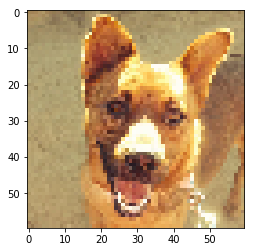

afghan_hound


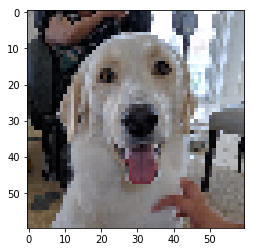

bernese_mountain_dog


In [22]:
# Load dog
# imsave('/gdrive/Team Drives/CS147 - Cucumbers/validation_pics/bella.jpg')
#import imageio
bella = PIL.Image.open('/gdrive/Team Drives/CS147 - Cucumbers/validation_pics/bella_square.jpg')
maru = PIL.Image.open('/gdrive/Team Drives/CS147 - Cucumbers/validation_pics/maru_square.jpg')
bella = bella.resize([img_size, img_size])
maru = maru.resize([img_size, img_size])
bella_arr = np.array(bella)
maru_arr = np.array(maru)
bella_arr = np.resize(bella, [1, 60, 60, 3])
maru_arr = np.resize(maru, [1, 60, 60, 3])


pred = model.predict(bella_arr)
for i in range(Nber_of_breeds):
  if pred[0][i] == 1:
    plt.imshow(bella)
    plt.show()
    print(name_labels[i])
    break
    
pred = model.predict(maru_arr)
for i in range(Nber_of_breeds):
  if pred[0][i] == 1:
    plt.imshow(maru)
    plt.show()
    print(name_labels[i])
    break